# Training the speech synthesis model - 3rd try

## Loading and cleaning spectrogram data

The first step that will be needed is to load spectrogram data. Since some files are missing, a few of the spectrograms will be completely empty and we would like to remove those.

Challenge: Demonstrate that MXNet is a state-of-the-art deep learning framework

Why is it important: Cloud providers sell infrastructure specialized at running their frameworks. Owning a popular framework helps providers sell cloud services, which are becoming increasingly popular.

What we are doing:
Implementing an end-to-end text-to-speech system in MXNet (Tacotron) to showcase the framework.

Tacotron in MXNet
From text directly to speech

Deep learning with MXNet


In [1]:
#!pip install --pre --upgrade mxnet-cu90
#!pip uninstall -y gluonnlp

In [2]:
#!pip install --pre --upgrade mxnet-cu90

In [3]:
num_gpus=1
batch_size=16

In [4]:
import logging
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn, Block
from util import audio
import matplotlib.pyplot as plt
import pickle

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [5]:
%run gluonnlpModelAttention.py

In [6]:
#load everything
lstTextEncodings = pickle.load( open( "data/lsttxtencodings.p", "rb" ) )
lst_linspectrograms = pickle.load( open( "data/lstlinspectrograms.p", "rb" ) )
lst_melspectrograms = pickle.load( open( "data/lstmelspectrograms.p", "rb" ) )

Let us do some sanity check. We know that audio 400 is:

She never @ went back to school , # even later on when both of their sons were older , @ # and she thinks that Jeff's criticisms grew out of what he saw as her lack @ of ambition . # 

File: HAW-157-02

In [7]:
linspectrogram = lst_linspectrograms[400]
melspectrogram = lst_melspectrograms[400]
lstTextEncodings[400]

array([24, 13, 10,  0, 19, 10, 27, 10, 23,  0,  2,  0, 28, 10, 19, 25,  0,
        7,  6,  8, 16,  0, 25, 20,  0, 24,  8, 13, 20, 20, 17,  0,  3,  0,
        2,  0, 10, 27, 10, 19,  0, 17,  6, 25, 10, 23,  0, 20, 19,  0, 28,
       13, 10, 19,  0,  7, 20, 25, 13,  0, 20, 11,  0, 25, 13, 10, 14, 23,
        0, 24, 20, 19, 24,  0, 28, 10, 23, 10,  0, 20, 17,  9, 10, 23,  0,
        3,  0,  2,  0,  2,  0,  6, 19,  9,  0, 24, 13, 10,  0, 25, 13, 14,
       19, 16, 24,  0, 25, 13,  6, 25,  0, 15, 10, 11, 11,  2, 24,  0,  8,
       23, 14, 25, 14,  8, 14, 24, 18, 24,  0, 12, 23, 10, 28,  0, 20, 26,
       25,  0, 20, 11,  0, 28, 13,  6, 25,  0, 13, 10,  0, 24,  6, 28,  0,
        6, 24,  0, 13, 10, 23,  0, 17,  6,  8, 16,  0,  2,  0, 20, 11,  0,
        6, 18,  7, 14, 25, 14, 20, 19,  0,  4,  0,  2,  0])

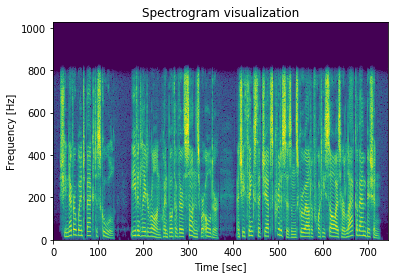

In [8]:
plt.pcolormesh(linspectrogram)
plt.title('Spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

We can also synthesize the audio to make sure it corresponds to what it should.

In [9]:
%%time
reconst_wav = audio.inv_spectrogram(linspectrogram)

Reconstructing with 60 iterations
CPU times: user 8.32 s, sys: 56 ms, total: 8.38 s
Wall time: 8.31 s


In [10]:
audio.save_wav(path='data/reconstrSANITYTrain.wav', wav=reconst_wav)

Let us now find and delete rows that correspond to blanks.

In [11]:
emptyIdx = []
for i in range(len(lst_linspectrograms)):
    spec = lst_linspectrograms[i]
    if np.count_nonzero(spec) == 0:
        #print('{}-th index is all zeros'.format(i))
        emptyIdx.append(i)
print(len(emptyIdx))

71


In [12]:
lstTextEncodings = [i for j, i in enumerate(lstTextEncodings) if j not in emptyIdx]
lst_linspectrograms = [i for j, i in enumerate(lst_linspectrograms) if j not in emptyIdx]
lst_melspectrograms = [i for j, i in enumerate(lst_melspectrograms) if j not in emptyIdx]

One last thing: if not all files have been processed, the text encodings will have more samples than the spectrograms.

In [13]:
lstTextEncodings = lstTextEncodings[:len(lst_linspectrograms)]
len(lstTextEncodings)

3143

In [14]:
nmax = len(lstTextEncodings) // 32 * 32
lstTextEncodings = lstTextEncodings[:nmax]
lst_linspectrograms = lst_linspectrograms[:nmax]
lst_melspectrograms = lst_melspectrograms[:nmax]
len(lst_melspectrograms)

3136

In [15]:
import psutil
mem = psutil.virtual_memory()
mem.available/mem.total

0.8866952362153158

## Padding and DataLoader

Padding will allow us to use gluon Dataset and Dataloader, which are more efficient ways to handle the batches.

In [16]:
max_sentence_length = 200
max_spectrog_width  = 700

In [17]:
padded_encodings = []
padded_linspecs  = []
padded_melspecs  = []
nTextEncs = len(lstTextEncodings)
for k in range(nTextEncs):
    if lstTextEncodings[k].shape[0] < max_sentence_length and lst_linspectrograms[k].shape[1] < max_spectrog_width:
        p_e = np.pad(lstTextEncodings[k], (0,  max_sentence_length - lstTextEncodings[k].shape[0]), 'constant', constant_values=(0, 0))
        padded_encodings.append(p_e)
        
        melspecw = max_spectrog_width - lst_melspectrograms[k].shape[1]
        p_mel = np.pad(lst_melspectrograms[k], ((0,0), (0,melspecw)), 'constant', constant_values=((0, 0),(0,0)) )
        padded_melspecs.append(p_mel)
        
        linspecw = max_spectrog_width - lst_linspectrograms[k].shape[1]
        p_lin = np.pad(lst_linspectrograms[k], ((0,0), (0,linspecw)), 'constant', constant_values=((0, 0),(0,0)) )
        padded_linspecs.append(p_lin)

print('Working with {} samples'.format(len(padded_encodings)))

Working with 2854 samples


In [18]:
dataset = mx.gluon.data.dataset.ArrayDataset(padded_encodings, padded_melspecs, padded_linspecs)
from multiprocessing import cpu_count
CPU_COUNT = cpu_count()

data_loader = mx.gluon.data.DataLoader(dataset, batch_size=batch_size*num_gpus, num_workers=CPU_COUNT, shuffle=True)

In [19]:
ctx = mx.cpu()
dataset[10][2].shape

(1025, 700)

In [20]:
encTest=None
melTest=None
linTest=None
for (encoding, melspec, linspec) in data_loader:
    encTest = encoding
    melTest = melspec
    linTest = linspec
    break

In [21]:
encTest


[[ 9 20  8 ...,  0  0  0]
 [25 23 14 ...,  0  0  0]
 [ 6 25  0 ...,  0  0  0]
 ..., 
 [24 20 18 ...,  0  0  0]
 [24 20  0 ...,  0  0  0]
 [ 9 20  0 ...,  0  0  0]]
<NDArray 16x200 @cpu_shared(0)>

# Create the model

Let us create a function to do the concatenation

## Embedding

We perform individual embedding of each sequence. Let's define an embedding layer here. Later on it will be part of the full net. Let's say for this part that the number of symbols we consider is 32.

In [22]:
vocab_size=32
embedding_dim = 256


In [23]:
#vocab size, embedding dimension
embedding = nn.Embedding(input_dim=32, output_dim=256)
embedding.initialize(ctx=ctx)

In [24]:
ndbatch = nd.array(encTest, dtype=int).as_in_context(ctx)
encTest


[[ 9 20  8 ...,  0  0  0]
 [25 23 14 ...,  0  0  0]
 [ 6 25  0 ...,  0  0  0]
 ..., 
 [24 20 18 ...,  0  0  0]
 [24 20  0 ...,  0  0  0]
 [ 9 20  0 ...,  0  0  0]]
<NDArray 16x200 @cpu_shared(0)>

In [25]:
emb = embedding(ndbatch)
emb.shape

(16, 200, 256)

## prenet

In [26]:
class PreNet(gluon.Block):
    def __init__(self, **kwargs):
        super(PreNet, self).__init__(**kwargs)
        
        with self.name_scope():
            self.fc1 = nn.Dense(256, activation='relu', flatten=False)
            self.dp1 = nn.Dropout(rate=0.5)
            self.fc2 = nn.Dense(128, activation='relu', flatten=False)
            self.dp2 = nn.Dropout(rate=0.5)
            
    def forward(self, x):
        logging.debug(type(x))
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        return x

# GRU with all intermediate outputs

In [27]:
#returns all intermediate hidden outputs along with the real outputs
class GRUWithAllHidden(gluon.Block):
    def __init__(self, units, **kwargs):
        super(GRUWithAllHidden, self).__init__(**kwargs)
        self.gruUnits = units
        with self.name_scope():
            self.grucellFwd = rnn.GRUCell(units)
            self.grucellBkw = rnn.GRUCell(units)
            
    def forward(self, x):
        #Input: x: (sequence_len, batch_size, val_dim)
        #Output: all outputs and hidden states of the 2 GRU cell (fwd and bwd) concatenated
        #shapes: (sequence_len, batch_size, units*2)

        seq_len = x.shape[0]
        batch_size = x.shape[1]
        
        hiddenFwd = [nd.zeros((batch_size, self.gruUnits)).as_in_context(ctx)]
        hiddenBkw = [nd.zeros((batch_size, self.gruUnits)).as_in_context(ctx)]
        
        #list of forward and backward hidden units and outputs
        hFwdList = []
        hBkwList = []
        oFwdList = []
        oBkwList = []
        
        for k in range(seq_len):
            outFwd, hiddenFwd = self.grucellFwd(x[k], hiddenFwd)
            outBkw, hiddenBkw = self.grucellBkw(x[seq_len - k - 1], hiddenBkw)
            
            hFwdList.append(hiddenFwd)
            hBkwList.append(hiddenBkw)
            oFwdList.append(outFwd)
            oBkwList.append(outBkw)
        
        #combine forward and backward passes
        allouts = None
        allhiddens = None
        
        for k in range(seq_len):
            hOut1 = hFwdList[k][0]
            hOut2 = hBkwList[seq_len - k - 1][0]
            oOut1 = oFwdList[k]
            oOut2 = oBkwList[seq_len - k - 1]
            
            combH = nd.concat(hOut1, hOut2, dim=1)
            combO = nd.concat(oOut1, oOut2, dim=1)
            
            combH = combH.reshape((1,combH.shape[0],combH.shape[1]))
            combO = combO.reshape((1,combO.shape[0],combO.shape[1]))
            
            if allouts is None:
                allouts = combO
                allhiddens = combH
            else:
                allouts = nd.concat(allouts, combO, dim=0)
                allhiddens = nd.concat(allhiddens, combH, dim=0)
            
        
        return allouts, allhiddens

## CBHG with GRUAllHidden

In [28]:
class CBHG(Block):
    def __init__(self, hiddensize, fcoutputsize, batch_size=32):
        super(CBHG, self).__init__()
        self.conv = []
        self.hiddensize = hiddensize
        with self.name_scope():
            
            self.conv = nn.Conv1D(channels=128*16, kernel_size=2*2+2, padding=2+1, activation='relu')
                
            self.maxpool0 = nn.MaxPool1D(pool_size=2, strides=1)
            self.bn0 = nn.BatchNorm()
            
            #projections
            self.convProj1 = nn.Conv1D(channels=128, kernel_size=3, padding=1, activation='relu')
            self.bn1 = nn.BatchNorm()
            self.convProj2 = nn.Conv1D(channels=128, kernel_size=3, padding=1, activation=None)
            self.bn2 = nn.BatchNorm()
            
            #Highway net: 4 layers of FC-128-ReLU
            self.fc1 = nn.Dense(units=128, activation='relu', flatten=False)
            self.fc2 = nn.Dense(units=128, in_units=128, activation='relu', flatten=False)
            self.fc3 = nn.Dense(units=128, in_units=128, activation='relu', flatten=False)
            self.fc4 = nn.Dense(units=fcoutputsize, in_units=128, activation='relu', flatten=False)

            
            #self.bidirecgru = GRUWithAllHidden(self.hiddensize)
            self.bidirecgru = rnn.GRU(self.hiddensize, bidirectional = True)
            

    def forward(self, x, batch_size = 32):
        #input: x(batch_size, seq_len, datalen=128)
        #print('xshape {}'.format(x.shape))
        
        seq_len = x.shape[1]
        
        #we need to apply convolutions in Time, not to the features
        x = x.transpose((0,2,1))
        xBkp = x
        
        #Conv1D -> input x as batch_size, num_channels =128, seq_len
        y = self.conv(x)
        
        #print(y[0].shape)
        x = self.maxpool0(y)
        x = self.bn0(x)

        x = self.convProj1(x)
        x = self.bn1(x)
        x = self.convProj2(x)
        x = self.bn2(x)
        
        #residual connection
        x = xBkp + x
        
        #highway
        #print('highway {}'.format(x.shape))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        #print('highway end {}'.format(x.shape))

        
        #x = x.reshape((seq_len, batch_size, -1))
        x = x.transpose((2,0,1))

        #print(xx.shape)
        #print(type(hidden))
        #print(hidden[0].shape)

        
        #print('GRU input {}'.format(x.shape))
        #x, newhidden = self.bidirecgru(x)
        x = self.bidirecgru(x)
        #print(newhidden[0].shape)
        
        return x


In [29]:
cbhg = CBHG(77, 128)
cbhg.initialize(ctx=ctx)
prenett=PreNet()
prenett.initialize(ctx=ctx)
preemb = prenett(emb)

In [30]:
outs = cbhg(preemb)
print(outs.shape)
#hiddens.shape

(128, 16, 154)


## Tacotron Init

In [31]:
class Tacotron(gluon.Block):
    def __init__(self, **kwargs):
        super(Tacotron, self).__init__(**kwargs)
        
        with self.name_scope():
            self.embedding = nn.Embedding(input_dim=32, output_dim=256)
            self.prenetEnc = PreNet()
            self.cbhg = CBHG(128, 128)
            
            self.prenetDec = PreNet()
            self.gruDec = rnn.GRUCell(256)

            self.Att = MLPAttentionCell(units=256)
            
            self.decRNN = rnn.GRUCell(256)
            
            self.fcDec1 = nn.Dense(units=128, in_units=256, activation='relu', flatten=False)
            self.fcDec2 = nn.Dense(units=80, in_units=128, activation='relu', flatten=False)
            
            self.fcDec1Lin = nn.Dense(units=512, in_units=256, activation='relu', flatten=False)
            self.fcDec2Lin = nn.Dense(units=1025, in_units=512, activation='relu', flatten=False)

            #self.postCBHG = CBHG(128, 80)
            
    def forward(self, x, myctx, ndmel_batch=None, mel_seqlen = 1800):
        #we receive x as ndarray with shape (batch_size, seq_len)
        if ndmel_batch is not None:
            logging.debug(ndmel_batch)
            mel_seqlen = ndmel_batch.shape[2]
            ndmel_batch = ndmel_batch.transpose((2,0,1))
        
        seq_size = x.shape[1]
        batch_size = x.shape[0]
        
        #encode
        x = self.embedding(x)
        x = self.prenetEnc(x)
        
        #xEnc, hEnc = self.cbhg(x, batch_size)
        xEnc = self.cbhg(x, batch_size)
        
        #print('encodings {}'.format(xEnc.shape))
        
        #cell = AttentionCell()
        #out = cell(query, key, value, mask)
        curframe = nd.zeros((batch_size, 80)).as_in_context(myctx)
        hiddenAttDec = [nd.zeros((batch_size, 256)).as_in_context(myctx)]
        hiddenRNNDec = [nd.zeros((batch_size, 256)).as_in_context(myctx)]
        
        melDecoded = None
        linDecoded = None
        #print(mel_seqlen)
        for k in range(mel_seqlen):
            #print('curframe {}'.format(curframe.shape))
            f = self.prenetDec(curframe)
            outDec, hiddenAttDec = self.gruDec(f, hiddenAttDec)
            
            #hiddenDec -> (batch_size, num_hidden)
            queryVec = hiddenRNNDec[0].reshape((batch_size, 1, -1)) #hiddenAttDec[0].reshape((batch_size, 1, -1))
            
            #print(xEnc.shape)
            
            vals = xEnc.transpose((1,0,2))
            keys = xEnc.transpose((1,0,2))#hEnc.transpose((1,0,2))
            
            #value ->  (batch_size, memory_length, total_value_dim)
            #query : (batch_size, query_length, query_dim)
            #key :  (batch_size, memory_length, key_dim)
            #context_vec : (batch_size, query_length, context_vec_dim) <-Returned?
            #we expect output of dimension (batch_size, 2*128=256). Looks like outputs are:
            #[weighted_vector attention_weights]
            
            #if k==0:
            #print('q{} k{} v{}'.format(queryVec.shape, keys.shape, vals.shape))
            attOutVec, attOutWeights = self.Att(queryVec, keys, vals)
            
            attOutVec = attOutVec.reshape((batch_size, -1))
            attOutVec = nd.concat(attOutVec, outDec, dim=1)
            
            logging.debug('attoutvec {}, outdec {}'.format(attOutVec.shape, outDec.shape))
            decoded, hiddenRNNDec = self.decRNN(attOutVec, hiddenRNNDec)
            
            curmeldecoded = self.fcDec1(decoded)
            curmeldecoded = self.fcDec2(curmeldecoded)
            
            #curmeldecoded = curmeldecoded*0.001 + curframe
            
            reshapedMelDecoded = curmeldecoded.reshape((1, curmeldecoded.shape[0], curmeldecoded.shape[1]))
            if melDecoded is None:
                melDecoded = reshapedMelDecoded
            else:
                melDecoded = nd.concat(melDecoded, reshapedMelDecoded, dim=0)            
            
            curlindecoded = self.fcDec1Lin(decoded)
            curlindecoded = self.fcDec2Lin(curlindecoded)            
            reshapedLinDecoded = curlindecoded.reshape((1, curlindecoded.shape[0], curlindecoded.shape[1]))
            if linDecoded is None:
                linDecoded = reshapedLinDecoded
            else:
                linDecoded = nd.concat(linDecoded, reshapedLinDecoded, dim=0)              
            
           
            #training - test difference
            #curframe = ndmel_batch[k,:,:]
            #curframe = curmeldecoded
            if ndmel_batch is not None: #if we have training data, input the truth
                curframe = ndmel_batch[k,:,:]
            else: #if not use this prediction as input
                curframe = curmeldecoded
        
        
        return melDecoded.transpose((1,2,0)), linDecoded.transpose((1,2,0))

## TCN

In [32]:
stn = Tacotron()
stn.initialize(ctx=ctx)
encTest.shape

(16, 200)

In [33]:
encTest = encTest.as_in_context(ctx)
melTest = melTest.as_in_context(ctx)
linTest = linTest.as_in_context(ctx)

meldec, lindec = stn(encTest, ctx, melTest)
meldec.shape

(16, 80, 700)

In [34]:
melTest.shape

(16, 80, 700)

In [35]:
sum([1,2,3])

6

## Training

In [36]:
import time
ctx = [mx.gpu(i) for i in range(num_gpus)]
logging.getLogger().setLevel(logging.INFO)

In [37]:
%run preprocess.py
ppt = PreProcessText('lowercaseonly')
nchars = len(ppt.validChars)
print('nchars = {}'.format(nchars)) #32
tcn=Tacotron()
#tcn.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
tcn.collect_params().initialize(mx.init.Uniform(scale=0.1), ctx=ctx)

nchars = 32


In [38]:
desired_loss = gluon.loss.L1Loss()
scheduler = mx.lr_scheduler.FactorScheduler(10000, 0.96,5e-5)
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': .0005, 'lr_scheduler': scheduler, 'clip_gradient':0.3})

In [39]:
cum_losses = []
mini_losses = []
ctx
def computeloss(x, melTrue, linTrue, localctx):
    logging.debug(melTrue.shape)
    decoded_melspec, decoded_linspec = tcn(x, localctx, melTrue)
    loss1 = desired_loss(decoded_melspec, melTrue)
    loss2 = desired_loss(decoded_linspec, linTrue)
    return loss1+loss2

In [40]:
epochs=120
epochNumber = 1
for e in range(epochs):
    cumulative_loss = 0
    num_examples=1
    i = 0
    curtime = time.time()
    
    for (encoding, melspec, linspec) in data_loader:
        #encoding = encoding.as_in_context(ctx)
        #melspec = melspec.as_in_context(ctx)
        #linspec = linspec.as_in_context(ctx)
        data = gluon.utils.split_and_load(encoding, ctx)
        melSpecs = gluon.utils.split_and_load(melspec, ctx)
        linSpecs = gluon.utils.split_and_load(linspec, ctx)
        
        with autograd.record():
            losses = [computeloss(data[i], melSpecs[i], linSpecs[i], ctx[i]) for i in range(len(ctx))]
        for loss in losses:
            loss.backward()
        
        #with autograd.record():
        #    decoded_melspec, decoded_linspec = tcn(encoding, ctx, melspec)
            
            #print('tgtlin {} tgtmel {} declin {} decmel {}'.format(ndtarget_lin.shape, ndtarget_mel.shape,decoded_linspec.shape, decoded_melspec.shape ))
        #    loss1 = desired_loss(decoded_melspec, melspec)
            #print(nd.sum(loss1))
        #    loss2 = desired_loss(decoded_linspec, linspec)
            #print(nd.sum(loss2))
        #    loss = loss1+loss2
        #loss.backward()
        
        #print('stepping')
        #TODO: see what is making grad stale
        trainer.step(batch_size)
        curloss = sum([nd.sum(loss).asscalar() for loss in losses])
        cumulative_loss += curloss
        mini_losses.append(curloss)
        #print(cumulative_loss)
        
        num_examples +=1
        i = i+1
        print('Minibatch {} Loss = {} '.format(i, cumulative_loss/num_examples), end='\r')
        
        #if i==5:
        #    break
        
    btime = time.time() - curtime
    cum_losses.append(cumulative_loss/num_examples) 
    
    if (e % 10 == 0):
        tcn.save_parameters('models/cbhgtacotron-epoch{}.model'.format(epochNumber))
    
    epochNumber += 1
    
    test_accuracy = 0 #evaluate_accuracy(test_data, net)
    train_accuracy = 0 #evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s, Time %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy, btime))

Process Process-5:
Process Process-8:
Process Process-6:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target

KeyboardInterrupt: 

In [41]:
#tcn.save_parameters('models/cbhgtacotron-cur.model')
#tcn.load_parameters('models/cbhgtacotron-cur.model')

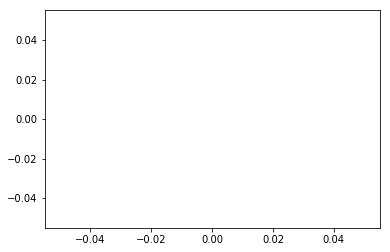

In [42]:
import matplotlib.pyplot as plt
plt.plot(cum_losses)
#cum_losses

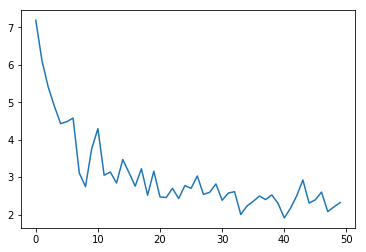

In [43]:
plt.plot(mini_losses)

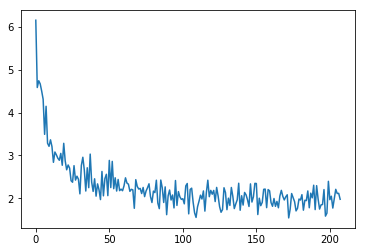

In [179]:
plt.plot(mini_losses)

In [161]:
encTest


[[24 20  0 ...,  0  0  0]
 [28 20 26 ...,  0  0  0]
 [28  6 24 ...,  0  0  0]
 ..., 
 [12 10 25 ...,  0  0  0]
 [28 13 10 ...,  0  0  0]
 [13 20 28 ...,  0  0  0]]
<NDArray 16x200 @cpu(0)>

In [170]:
decoded_melspec, decoded_linspec = tcn(encTest.as_in_context(ctx[0]), ctx[0], melTest.as_in_context(ctx[0]))
print(linTest.shape)
print(melTest.shape)

(16, 1025, 700)
(16, 80, 700)


In [171]:
idx = 7
nplinspec_dec = decoded_linspec[idx,:,:].asnumpy()
nplinspec_tgt = linTest[idx,:,:].asnumpy()
npmelspec_dec = decoded_melspec[idx,:,:].asnumpy()
npmelspec_tgt = melTest[idx,:,:].asnumpy()

nplinspec_dec.shape

(1025, 700)

In [172]:
nplinspec_tgt.shape

(1025, 700)

In [173]:
npmelspec_tgt.max()

0.78176743

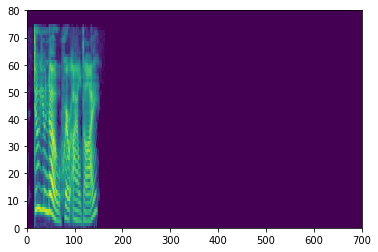

In [174]:
plt.pcolormesh(npmelspec_tgt)
plt.show()

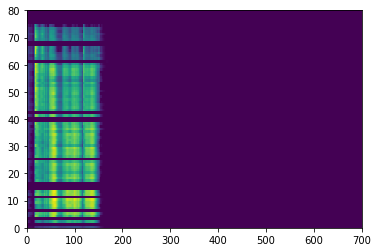

In [175]:
plt.pcolormesh(npmelspec_dec)
plt.show()

In [72]:
%%time
recTgt = audio.inv_spectrogram(nplinspec_tgt)
audio.save_wav(path='data/recTarget.wav', wav=recTgt)

Reconstructing with 60 iterations


ValueError: operands could not be broadcast together with shapes (800,1025) (1025,1025) 

In [193]:
recTgt.max()

28322.307313752535

In [194]:
%%time
recDec = audio.inv_spectrogram(nplinspec_dec)
audio.save_wav(path='data/recReconst.wav', wav=recDec*50)

Reconstructing with 60 iterations
CPU times: user 9.28 s, sys: 0 ns, total: 9.28 s
Wall time: 9.28 s


In [195]:
recDec.max()

0.84672858293299824

In [105]:
2000000/500

4000.0

In [326]:

#tcn.save_params('simpletacotron.model')

In [185]:
tcn.load_params('models/cbhgtacotron-epoch82.model', ctx)